In [1]:
import pandas as pd,numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
for column in df.columns.tolist():

    plt.figure(figsize = (8,6))

    if df[column].nunique() > 10:

        sns.histplot(x = df[column])

    else:

        sns.countplot(x = df[column])
    
    plt.title(column)
    plt.show()

How many values do we have with cholesterol == 0?

In [4]:
print(f"Values where cholesterol is zero: {len(df[df.Cholesterol == 0])}")

Values where cholesterol is zero: 172


In [5]:
df.loc[df.Cholesterol == 0,'Cholesterol'] = np.nan

In [33]:
for column in df.columns.tolist():
    print(column,df[column].nunique())

Age 50
Sex 2
ChestPainType 4
RestingBP 67
Cholesterol 222
FastingBS 2
RestingECG 3
MaxHR 119
ExerciseAngina 2
Oldpeak 53
ST_Slope 3
HeartDisease 2


In [21]:
from sklearn.base import BaseEstimator,TransformerMixin

class MultiColumnEncoder(BaseEstimator,TransformerMixin):
    
    def __init__(self,
                 columns_to_encode:list = None,
                 encoder_dict: dict = None,
                 base_encoder = OrdinalEncoder()) -> pd.DataFrame:

        #Set the user-definied column list to the class attribute _columns_to_encode
        self.columns_to_encode = columns_to_encode

        if base_encoder is None:
            self.base_encoder = OrdinalEncoder()
        else:
            self.base_encoder = base_encoder

        #If the user passes their own encoder dict
        if not encoder_dict:
            self.encoder_dict = {column:self.base_encoder for column in self.columns_to_encode}
        else:
            self.encoder_dict = encoder_dict
    
    def fit(self,X,y = None):
        pass

    def fit_transform(self,X,y = None):

        if not isinstance(X,pd.DataFrame):
            raise Exception(f"Input datatype must be Pandas Dataframe.  Object passed was of type {type(X)}")
        
        for column in self.columns_to_encode:
            if column not in X.columns.tolist():
                raise Exception(f"{column} is mising from the input Dataframe")
        
        df = X.copy()

        for column in df.columns.tolist():

            if column not in self.columns_to_encode:
                continue

            df[column] = self.encoder_dict[column].fit_transform(df[column].to_numpy().reshape(-1,1))
        
        return df
    
    def transform(self,X,y = None):
        
        df = X.copy()

        for column in df.columns:

            if column in self.encoder_dict.keys():

                df[column] = self.encoder_dict[column].transform(df[column].to_numpy().reshape(-1,1))
        
        return df


        
        
test = MultiColumnEncoder(['Sex','ExerciseAngina','ChestPainType'],base_encoder=OrdinalEncoder(dtype = 'int64',handle_unknown='use_encoded_value',unknown_value=100))
test.encoder_dict

{'Sex': OrdinalEncoder(dtype='int64', handle_unknown='use_encoded_value',
                unknown_value=100),
 'ExerciseAngina': OrdinalEncoder(dtype='int64', handle_unknown='use_encoded_value',
                unknown_value=100),
 'ChestPainType': OrdinalEncoder(dtype='int64', handle_unknown='use_encoded_value',
                unknown_value=100)}

In [36]:
X,y = df.drop('HeartDisease',axis = 1),df.HeartDisease.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=226)

pipe = Pipeline([
    ('multi_column_encoder',MultiColumnEncoder(['Sex','ExerciseAngina','ChestPainType','RestingECG','ST_Slope'],
                                                base_encoder=OrdinalEncoder(dtype = 'int64',
                                                                            handle_unknown='use_encoded_value',
                                                                            unknown_value=100))),
    ('random_forest',RandomForestClassifier(n_estimators=500))
])
pipe.fit(X_train,y_train)


Pipeline(steps=[('multi_column_encoder',
                 MultiColumnEncoder(base_encoder=OrdinalEncoder(dtype='int64',
                                                                handle_unknown='use_encoded_value',
                                                                unknown_value=100),
                                    columns_to_encode=['Sex', 'ExerciseAngina',
                                                       'ChestPainType',
                                                       'RestingECG',
                                                       'ST_Slope'],
                                    encoder_dict={'ChestPainType': OrdinalEncoder(dtype='int64',
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=100)...
                                                                                   unknown_value=100),
                                                  'RestingECG': OrdinalEncoder(dtype='int64',
                                                                               handle_unknown='use_encoded_value',
                                                                               unknown_value=100),
                                                  'ST_Slope': OrdinalEncoder(dtype='int64',
                                                                             handle_unknown='use_encoded_value',
                                                                             unknown_value=100),
                                                  'Sex': OrdinalEncoder(dtype='int64',
                                                                        handle_unknown='use_encoded_value',
                                                                        unknown_value=100)})),
                ('random_forest', RandomForestClassifier(n_estimators=500))])

In [37]:
pipe.score(X_test,y_test)

0.842391304347826

In [38]:
[(feature,importance) for feature,importance in zip(X_train.columns.tolist(),pipe['random_forest'].feature_importances_)]

[('Age', 0.08639815943518675),
 ('Sex', 0.04068326103835821),
 ('ChestPainType', 0.12902552619794655),
 ('RestingBP', 0.07254909310232148),
 ('Cholesterol', 0.1092861543226467),
 ('FastingBS', 0.02813796315742461),
 ('RestingECG', 0.027391851159859225),
 ('MaxHR', 0.10356095154064379),
 ('ExerciseAngina', 0.07068318375513369),
 ('Oldpeak', 0.10532507261065012),
 ('ST_Slope', 0.2269587836798289)]

c:\Users\fmath\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

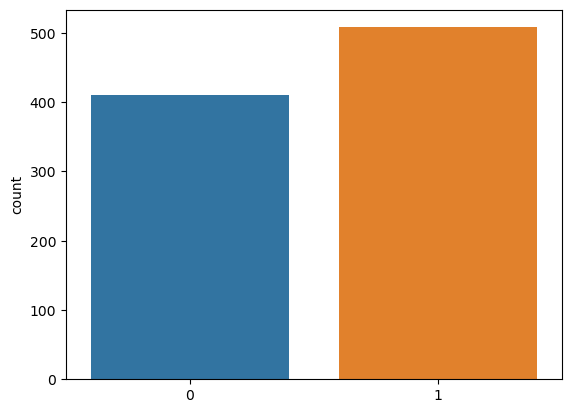

In [31]:
sns.countplot(y)